In [277]:
import pandas as pd
from cell_paint_seg.utils import get_id_to_path
from cell_paint_seg.experiment_layouts import (id_from_name_dataset, condition_from_id, line_from_id,
                                               line_to_class,
                                                condition_num_to_name)
import xgboost
import shap 
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


## Helper functions

In [255]:
res = 6.9e-7

## Read/format data

In [330]:
db_path = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/Rescale_AneeshFeats_all_Soma.csv"

df_og = pd.read_csv(db_path)

conditions = []
lines = []

for i,row in df_og.iterrows():
    id = row["FileName_ARD"][:-4]
    conditions.append(condition_from_id(id))
    lines.append(line_from_id(id))

# Add new column to df called "Condition"
df_og["Condition"] = conditions
df_og["Line"] = lines


# select only the columns with the string "AreaShape" in them
all_columns = df_og.columns
area_shape_columns = [col for col in all_columns if col[:4] == "Area"]
area_shape_columns = [col for col in area_shape_columns if "Orientation" not in col]
area_shape_columns = [col for col in area_shape_columns if "_X" not in col]
area_shape_columns = [col for col in area_shape_columns if "_Y" not in col]


intensity_columns = [col for col in all_columns if col[:4] == "Inte"]
neighbor_columns = [col for col in all_columns if col[:4] == "Neig"]
neighbor_columns = [col for col in neighbor_columns if "ObjectNumber" not in col]
neighbor_columns = [col for col in neighbor_columns if "Angle" not in col]

distrib_columns = [col for col in all_columns if col[:4] == "Radi"]
texture_columns = [col for col in all_columns if col[:4] == "Text"]
dep_columns = [col for col in all_columns if col in ["Condition", "Line"]]


indep_columns = area_shape_columns + intensity_columns + neighbor_columns + texture_columns + distrib_columns # excluded because of nans
meta_columns = [col for col in all_columns if col in ["FileName_ARD"]]
df = df_og[indep_columns + dep_columns + meta_columns]


# get the list of column indices that contain the word "AreaShape"
area_shape_indices = [indep_columns.index(col) for col in indep_columns if "AreaShape" in col]
neighbor_indices = [indep_columns.index(col) for col in indep_columns if "Neighbor" in col]
rna_indices = [indep_columns.index(col) for col in indep_columns if "RNA" in col and ("Intensity" in col or "Texture" in col)]
actin_indices = [indep_columns.index(col) for col in indep_columns if "Actin" in col and ("Intensity" in col or "Texture" in col)]
dna_indices = [indep_columns.index(col) for col in indep_columns if "DNA" in col and ("Intensity" in col or "Texture" in col)]


/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_14899/3475987384.py:3: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.read_csv(db_path)


## Filter

In [331]:
df = df.fillna(value=0)

In [304]:
df = df[df["AreaShape_Area"] > 200]
df = df[df["AreaShape_Area"] < 600]
df = df[df["Neighbors_PercentTouching_Adjacent"] < 50]
df = df[df["Neighbors_PercentTouching_5"] < 50]
df = df[df["Neighbors_NumberOfNeighbors_25"] < 10]

# remove rows with NaNs
df.shape

## Add columns/select subset

In [ ]:
df["ALS"] = df["Line"].apply(lambda x: line_to_class(x))
plates = ("e1", "e4")
df["Included"] = df["FileName_ARD"].apply(lambda x: 1 if (x[:2] in plates) else 0)
#df["Included"] = df["ALS"].apply(lambda x: 1 if (x > 0) else 0)

df_subset = df[df["Included"] == 1]

# df_subset["Included"] = df_subset["FileName_ARD"].apply(lambda x: 1 if (x[:2] in plates) else 0)
# df_subset = df_subset[df_subset["Included"] == 1]

states = df_subset["ALS"].unique()
# map the values of ALS to consecutive integers
state_map = {state: i for i, state in enumerate(states)}
df_subset["ALS"] = df_subset["ALS"].map(state_map)

lines_g1 = df_subset[df_subset["ALS"] == 0]["Line"].unique()
lines_g2 = df_subset[df_subset["ALS"] == 1]["Line"].unique()

print(f"Shape: {df_subset.shape}")
print(f"unq: {df_subset['ALS'].unique()}")
print(f"lines_g1: {lines_g1} vs lines_g2: {lines_g2}")


Shape: (58504, 272)
unq: [0 1]
lines_g1: ['RFTiALS' 'EGMiALS' 'DG9iALS'] vs lines_g2: ['ZLMiALS' 'RJViALS' 'BFUiALS']


/var/folders/gy/jk_d3cx54vj18w9sm6x3sg_80000gn/T/ipykernel_14899/3471686891.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["ALS"] = df_subset["ALS"].map(state_map)


Group 1 lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

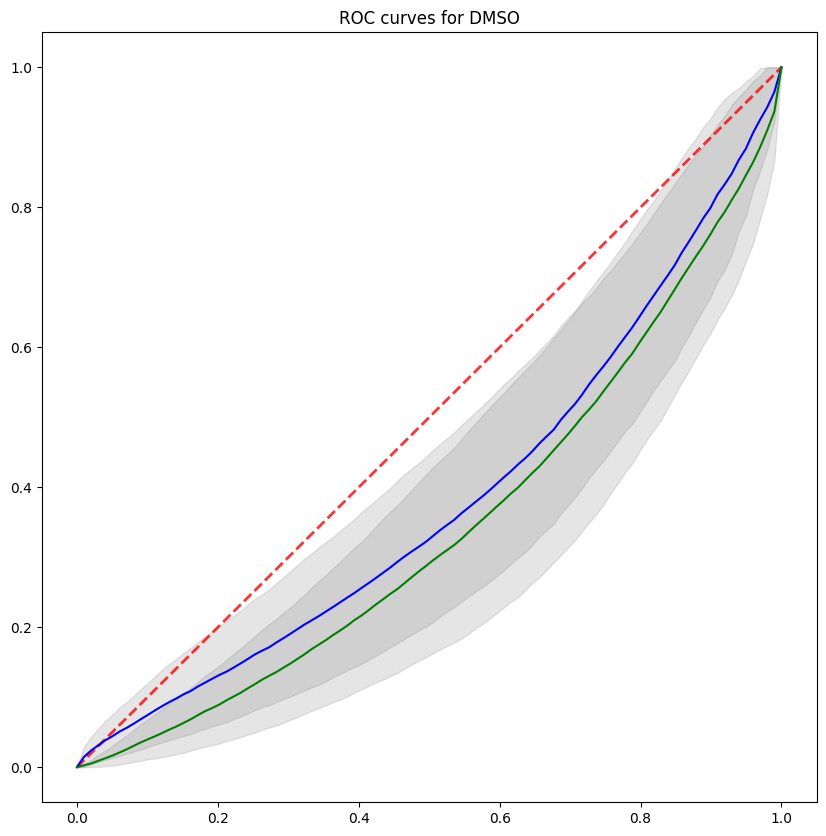

Group 1 lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

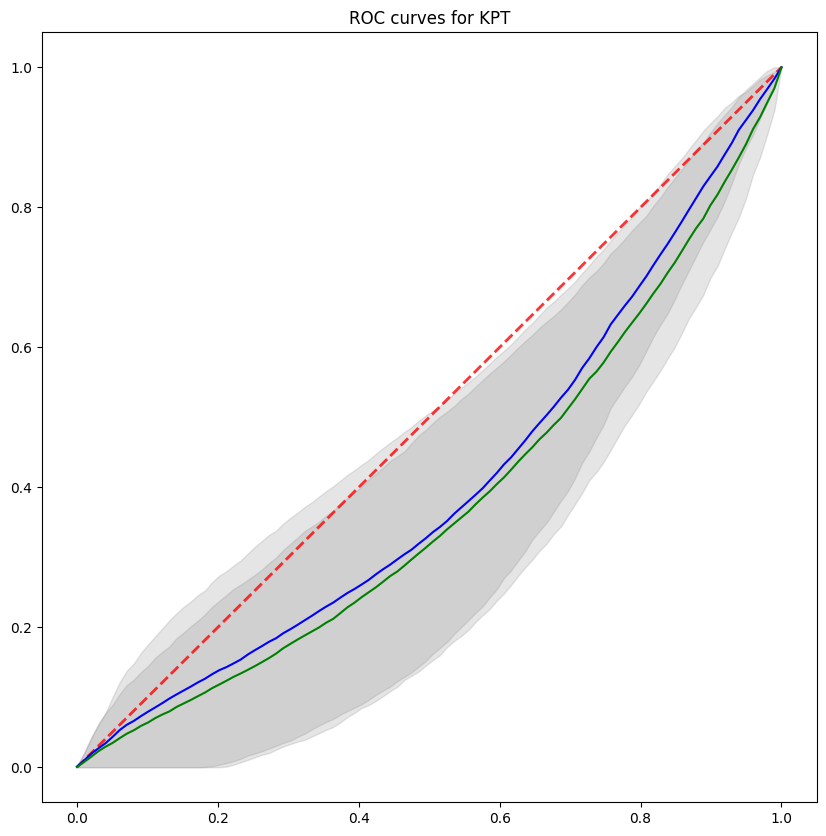

Group 1 lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

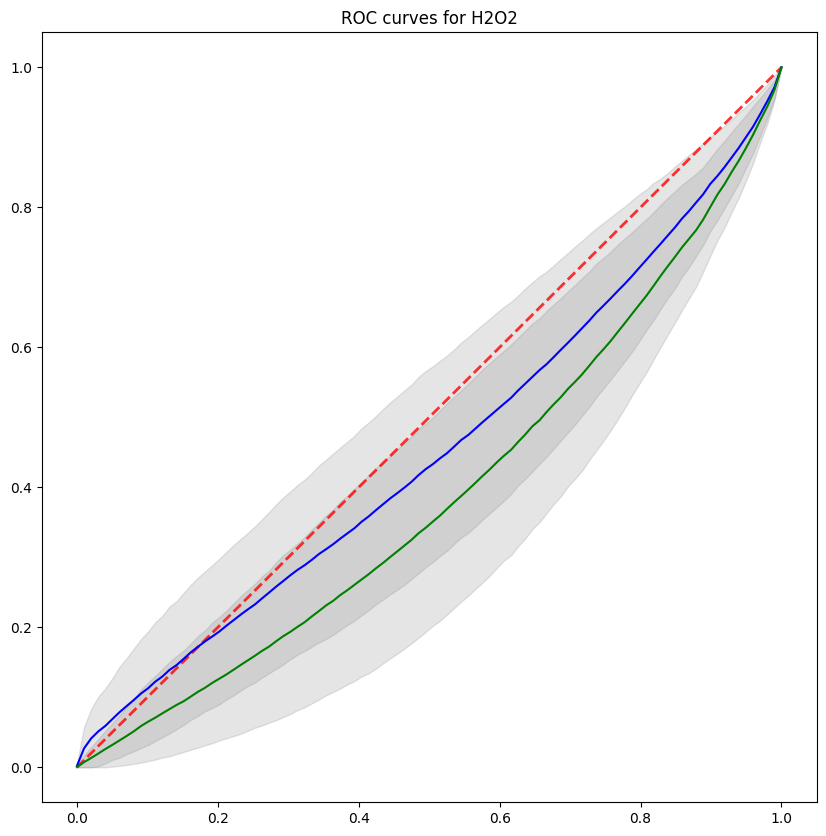

Group 1 lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

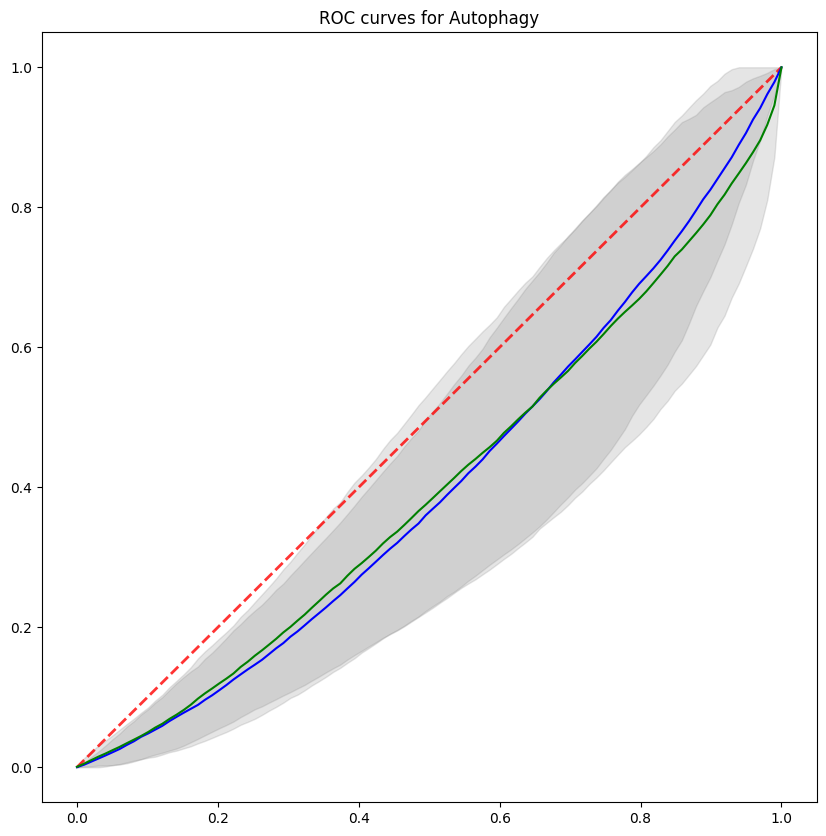

Group 1 lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

Group 2 Lines:   0%|          | 0/3 [00:00<?, ?it/s]

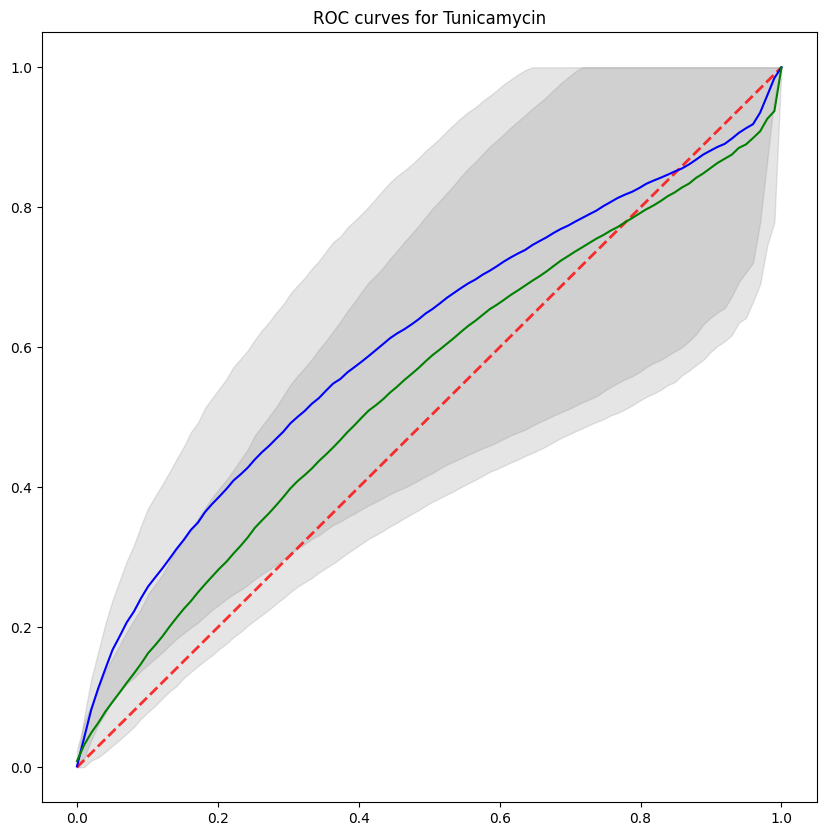

In [329]:
mean_fpr = np.linspace(0, 1, 100)

for c in df["Condition"].unique():
    tprs_log = []
    tprs_xgb = []
    for l in tqdm(lines_g1, desc="Group 1 lines"):
        for lc in tqdm(lines_g2, desc="Group 2 Lines", leave=False):
            df_subsubset = df_subset[df_subset["Condition"] == c]
            
            df_train = df_subsubset[(df_subsubset["Line"] == l) | (df_subsubset["Line"] == lc)]
            df_test = df_subsubset[(df_subsubset["Line"] != l) & (df_subsubset["Line"] != lc)]

            x_train = df_train[indep_columns]#.values
            #x_train = np.nan_to_num(x_train)
            y_train = df_train["ALS"].values

            # Fit models
            pipe_log = make_pipeline(StandardScaler(), LogisticRegression(solver="newton-cholesky"))
            pipe_log.fit(x_train, y_train)
            pipe_xgb = make_pipeline(StandardScaler(), xgboost.XGBClassifier())
            pipe_xgb.fit(x_train, y_train)

            x_test = df_test[indep_columns]#.values
            #x_test = np.nan_to_num(x_test)
            y_test = df_test["ALS"].values


            y_pred_proba = pipe_log.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
            f = interp1d(fpr, tpr)
            tprs_log.append(f(mean_fpr))

            y_pred_proba = pipe_xgb.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
            f = interp1d(fpr, tpr)
            tprs_xgb.append(f(mean_fpr))



    condition_name = condition_num_to_name(c)

    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot([0,1], [0,1], linestyle="--", lw=2, color="red", alpha=0.8, label="Chance")

    for tprs, color in zip([tprs_log, tprs_xgb], ["blue", "green"]):
        tprs = np.array(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

        ax.plot(mean_fpr, mean_tpr, color=color, label="Mean ROC")
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.2, label="Standard Deviation")

    ax.set_title(f"ROC curves for {condition_name}")
    plt.show()




        


/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Max Feature: Texture_SumAverage_RNA_rescaled_3_00_256
************DMSO********
XGBoost acc: 0.4980735551663748, auc: 0.5535935570193495
Logistic Regression acc: 0.3369527145359019, auc: 0.41119648003293535
Confusion Matrix
[[ 647 1088]
 [ 345  775]]


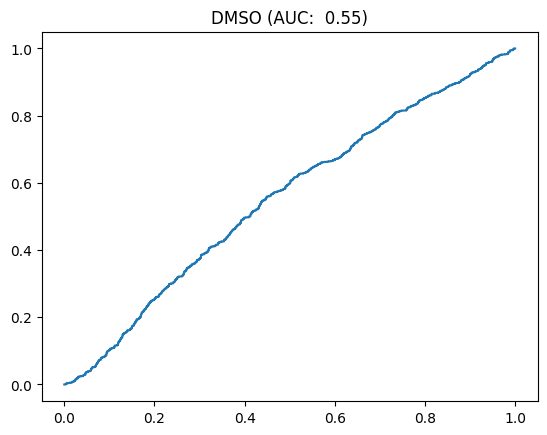

p-value: 0.9977 over prior accuracy of 0.5232823117338004


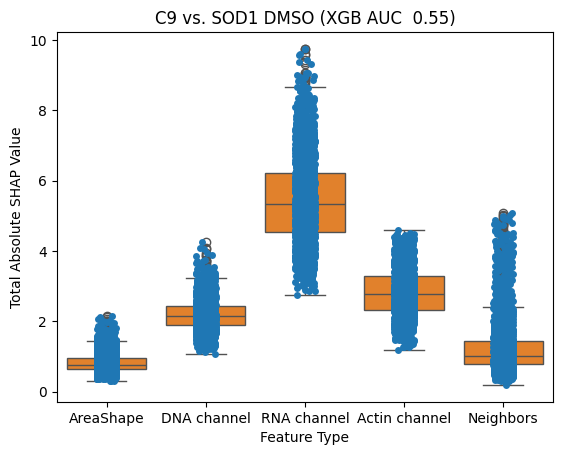

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Max Feature: Texture_SumVariance_Actin_rescaled_3_03_256
************KPT********
XGBoost acc: 0.5406397482957525, auc: 0.5384365074076541
Logistic Regression acc: 0.5280545359202936, auc: 0.5826891894893494
Confusion Matrix
[[247 613]
 [263 784]]


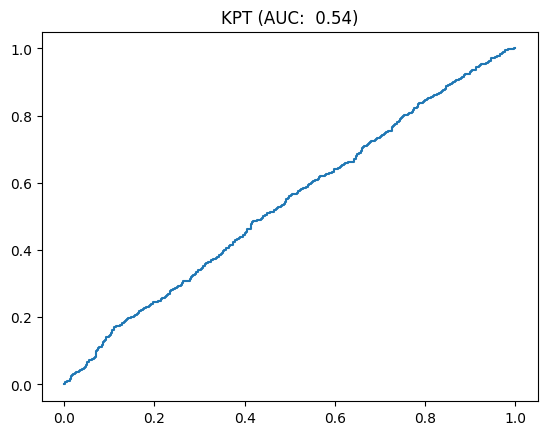

p-value: 0.0005 over prior accuracy of 0.5049134766649187


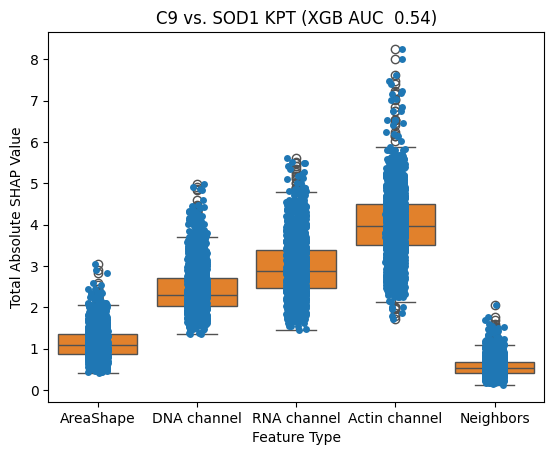

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Max Feature: AreaShape_Area
************H2O2********
XGBoost acc: 0.8054282692985548, auc: 0.8988633653519255
Logistic Regression acc: 0.5798378568910821, auc: 0.5694986121893917
Confusion Matrix
[[1418  204]
 [ 348  867]]


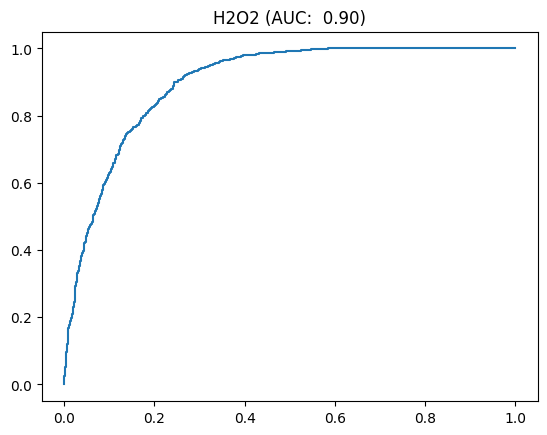

p-value: 0.0 over prior accuracy of 0.5105896721889319


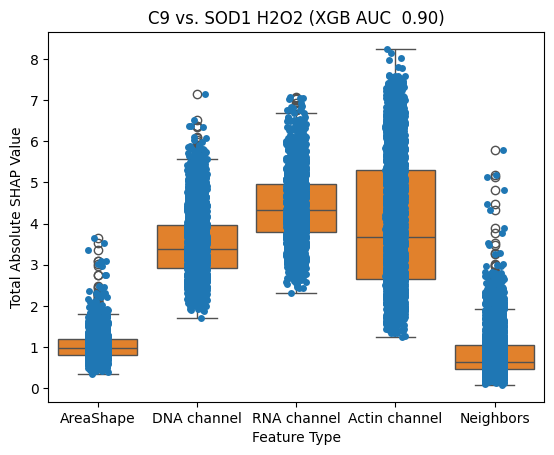

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Max Feature: Texture_SumAverage_RNA_rescaled_3_00_256
************Autophagy********
XGBoost acc: 0.5427745664739885, auc: 0.48393381037567085
Logistic Regression acc: 0.4208092485549133, auc: 0.3460912343470483
Confusion Matrix
[[782 518]
 [273 157]]


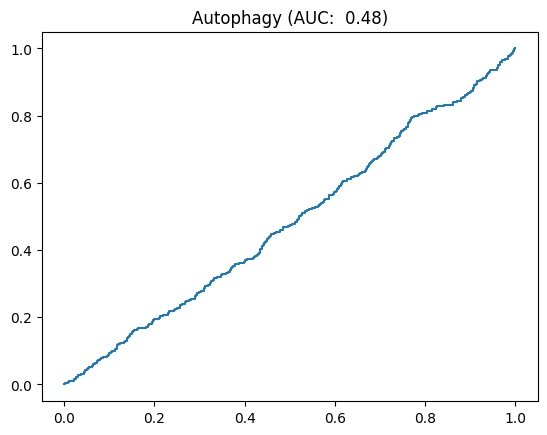

p-value: 1.0 over prior accuracy of 0.6264378034682081


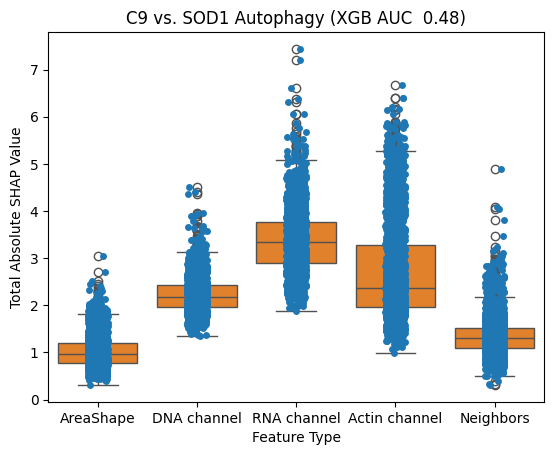

/Users/thomasathey/Documents/shavit-lab/fraenkel/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Max Feature: Intensity_IntegratedIntensity_RNA_rescaled
************Tunicamycin********
XGBoost acc: 0.8326539855072463, auc: 0.8734415362918098
Logistic Regression acc: 0.7350543478260869, auc: 0.7257909584091576
Confusion Matrix
[[3151  416]
 [ 323  526]]


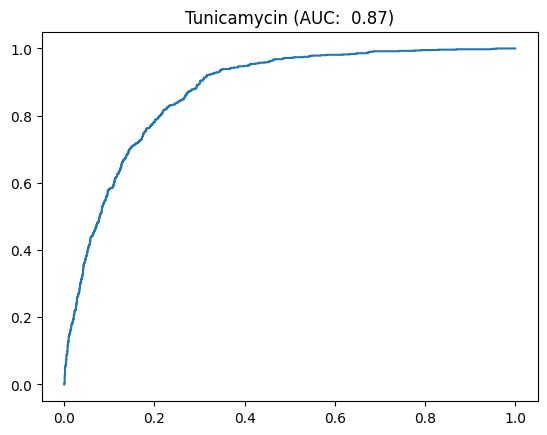

p-value: 0.0 over prior accuracy of 0.6893060235507246


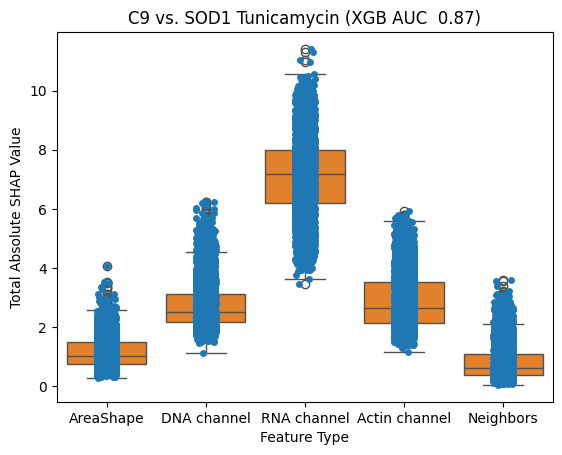

In [ ]:
cond_to_models = {}
cond_to_df_tests = {}
cond_to_explainers = {}

for c in df["Condition"].unique():
    df_subsubset = df_subset[df_subset["Condition"] == c]
    #df_subset = df_subset[df_subset["ALS"] != 0]

    df_train = df_subsubset[df_subsubset["Test"] == 0]
    df_test = df_subsubset[df_subsubset["Test"] == 1]

    x_train = df_train[indep_columns]#.values
    #x_train = np.nan_to_num(x_train)
    y_train = df_train["ALS"].values

    x_test = df_test[indep_columns]#.values
    #x_test = np.nan_to_num(x_test)
    y_test = df_test["ALS"].values

    model_log = LogisticRegression()
    model_log.fit(x_train, y_train)
    y_pred_proba = model_log.predict_proba(x_test)
    y_pred = model_log.predict(x_test)
    accuracy_log = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    auc_test_log = auc(fpr, tpr)

    # find the feature with the highest logistic regression coefficient
    max_index = np.argmax(np.abs(model_log.coef_))
    max_feature = indep_columns[max_index]
    print(f"Max Feature: {max_feature}")


    model = xgboost.XGBClassifier().fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    auc_test = auc(fpr, tpr)

    confusion_mat = confusion_matrix(y_test,y_pred)

    condition_name = condition_num_to_name(c)
    print(f"************{condition_name}********")
    print(f"XGBoost acc: {accuracy}, auc: {auc_test}")
    print(f"Logistic Regression acc: {accuracy_log}, auc: {auc_test_log}")
    print("Confusion Matrix")
    print(confusion_mat)

    plt.plot(fpr, tpr)
    plt.title(f"{condition_name} (AUC: {auc_test: .2f})")
    plt.show()


    marginals = np.sum(confusion_mat, axis=1)
    k = len(marginals)
    pvals = marginals / np.sum(marginals)#[1/float(k)] * k

    accs = []
    for iter in range(10000):
        rand_mat = []
        for marginal in marginals:
            row = np.random.multinomial(marginal, pvals = pvals)
            rand_mat.append(row)

        rand_mat = np.stack(rand_mat, axis=0)
        
        acc = np.sum(rand_mat.diagonal())/np.sum(rand_mat)
        accs.append(acc)

    accs = np.array(accs)
    pval = np.sum(accs >= accuracy)/len(accs)
    print(f"p-value: {pval} over prior accuracy of {np.mean(accs)}")

    explainer = shap.Explainer(model_log, x_train)
    explainer = shap.Explainer(model)
    shap_values = explainer(x_test)


    cond_to_models[c] = model_log
    cond_to_df_tests[c] = df_test
    cond_to_explainers[c] = explainer
    
    data_shap = []
    data_type = []

    for feature_set_name, feature_set in zip(["AreaShape", "DNA channel", "RNA channel", "Actin channel", "Neighbors"],[area_shape_indices, dna_indices, rna_indices, actin_indices, neighbor_indices]):
        mean_abs = np.sum(np.abs(shap_values.values[:,feature_set]), axis=1)
        data_shap += list(mean_abs)
        data_type += [feature_set_name]*len(mean_abs)

    df_shap = pd.DataFrame({"Total Absolute SHAP Value":data_shap, "Feature Type":data_type})
    sns.stripplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
    sns.boxplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
    plt.title(f"C9 vs. SOD1 {condition_name} (XGB AUC {auc_test: .2f})")
    plt.show()

## Shap

In [193]:
condition = "H2O2"
cond_num = condition_num_to_name(condition, inverse=True)

explainer = cond_to_explainers[cond_num]
model = cond_to_models[cond_num]
df_test = cond_to_df_tests[cond_num]
x_test = df_test[indep_columns]

shap_values = explainer(x_test)

print(f"values: {shap_values.values.shape}, base_values: {shap_values.base_values.shape}, data: {shap_values.data.shape}")

values: (2837, 238), base_values: (2837,), data: (2837, 238)


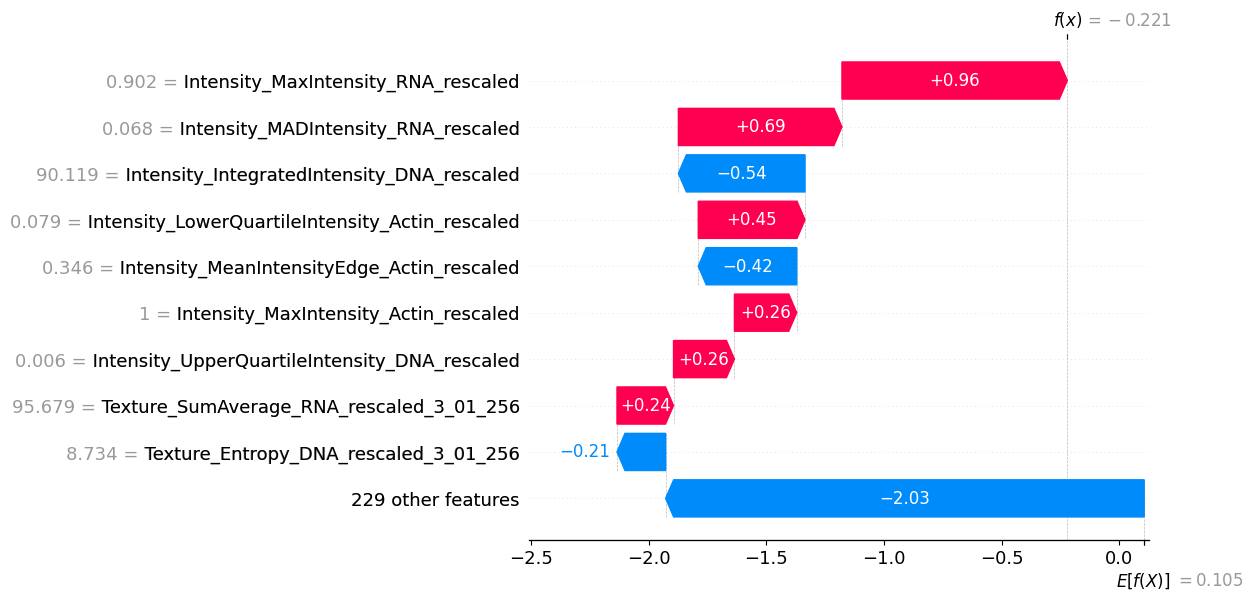

In [194]:
# # visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0,:])

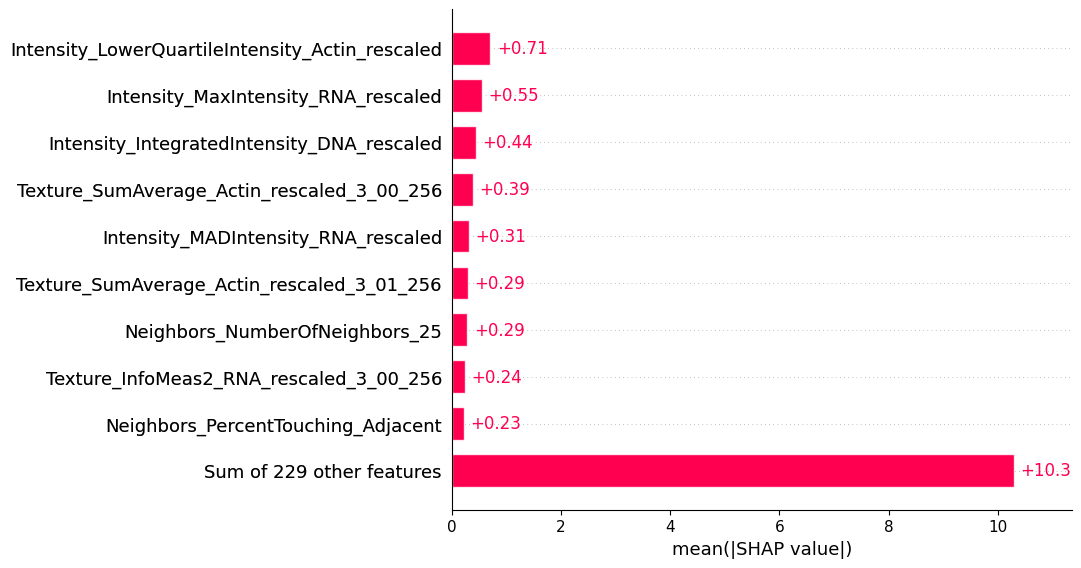

In [195]:
shap.plots.bar(shap_values)

<Axes: xlabel='Feature Type', ylabel='Total Absolute SHAP Value'>

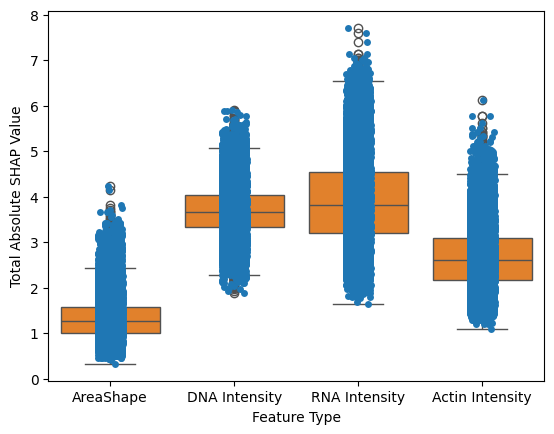

In [167]:
data_shap = []
data_type = []

for feature_set_name, feature_set in zip(["AreaShape", "DNA Intensity", "RNA Intensity", "Actin Intensity"],[area_shape_indices, dna_indices, rna_indices, actin_indices]):
    mean_abs = np.sum(np.abs(shap_values.values[:,feature_set]), axis=1)
    data_shap += list(mean_abs)
    data_type += [feature_set_name]*len(mean_abs)

df_shap = pd.DataFrame({"Total Absolute SHAP Value":data_shap, "Feature Type":data_type})
sns.stripplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")
sns.boxplot(df_shap, x="Feature Type", y="Total Absolute SHAP Value")

## View Image

In [172]:
# Get column number of IntensityMaxIntensity_RNA in x_test
col_num = x_test.columns.get_loc("Neighbors_NumberOfNeighbors_25")

col_vals = shap_values.values[:,col_num]
idxs = np.argsort(col_vals)

print(df_test.iloc[idxs[1]])

print(df_test.iloc[idxs[-1]])

AreaShape_Area                               207
AreaShape_BoundingBoxArea                    360
AreaShape_BoundingBoxMaximum_X               556
AreaShape_BoundingBoxMaximum_Y               240
AreaShape_BoundingBoxMinimum_X               526
                                       ...      
Line                                     RFTiALS
FileName_ARD                      e6_wC10_f3.tif
ALS                                            0
Included                                       1
Test                                           1
Name: 425884, Length: 244, dtype: object
AreaShape_Area                               41
AreaShape_BoundingBoxArea                    56
AreaShape_BoundingBoxMaximum_X              358
AreaShape_BoundingBoxMaximum_Y               26
AreaShape_BoundingBoxMinimum_X              350
                                      ...      
Line                                    BFUiALS
FileName_ARD                      e6_wG6_f2.tif
ALS                                 

In [160]:
df_test.iloc[idxs[0]]["Intensity_MADIntensity_RNA_rescaled"]

0.0638297796249389

# Results

## CellProfiler

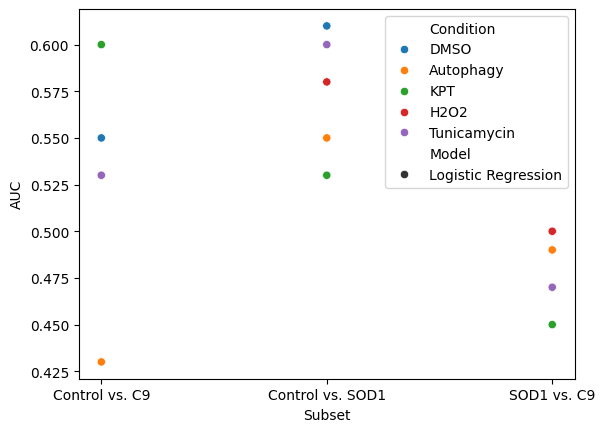

In [128]:
conditions = ["DMSO", "Autophagy", "KPT", "H2O2", "Tunicamycin"] * 3
subset = ["Control vs. C9"] * 5 + ["Control vs. SOD1"] * 5 + ["SOD1 vs. C9"] * 5
subset = subset * 2
conditions = conditions * 2

accs = [0.57, 0.55, 0.44, 0.55, 0.67,
        0.59, 0.58, 0.44, 0.59, 0.63,
        0.51, 0.48, 0.49, 0.5, 0.65] 

accs_log = [0.55, 0.43, 0.6, 0.53, 0.53,
            0.61, 0.55, 0.53, 0.58, 0.6,
            0.5, 0.49, 0.45, 0.5, 0.47]

aucs = accs + accs_log

models = ["XGBoost"] * 15 + ["Logistic Regression"] * 15

data = {"Condition": conditions, "Subset": subset, "AUC": aucs, "Model": models}

df_accs = pd.DataFrame(data)

sns.scatterplot(df_accs[df_accs["Model"] == "Logistic Regression"], x="Subset", y="AUC", hue="Condition", style="Model")
plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/presentation/classification/aucs_log.svg")

## All methods

<Axes: xlabel='Condition', ylabel='Accuracy'>

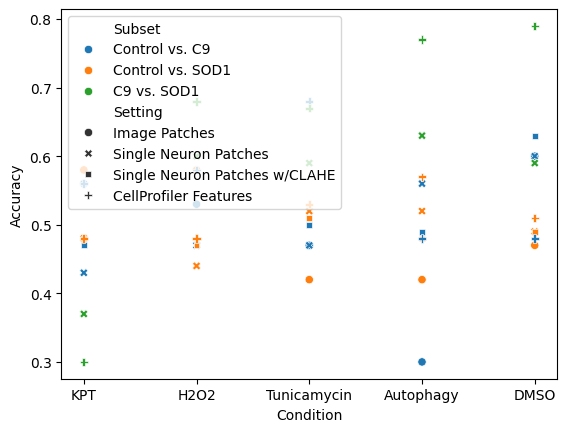

In [50]:
accs = [0.56, 0.53, 0.47, 0.3, 0.60, 0.58, 0.58, 0.42, 0.42, 0.47,
        0.43, 0.47, 0.47, 0.56, 0.60, 0.48, 0.44, 0.52, 0.52, 0.49,
        0.37, 0.6, 0.59, 0.63, 0.59,
        0.47, 0.47, 0.5, 0.49, 0.63, 0.48, 0.47, 0.51, 0.48, 0.49]
conditions = ["KPT", "H2O2", "Tunicamycin", "Autophagy", "DMSO"] * 7
settings = ["Image Patches"] * 10 + ["Single Neuron Patches"] * 15 + ["Single Neuron Patches w/CLAHE"] * 10
subset = ((["Control vs. C9"] * 5 + ["Control vs. SOD1"] * 5) * 2 + ["C9 vs. SOD1"] * 5)*2
subset = subset[:35]

#cellprofiler results
accs += [0.56, 0.58, 0.68, 0.48, 0.48,
         0.48, 0.48, 0.53, 0.57, 0.51,
         0.3, 0.68, 0.67, 0.77, 0.79]
conditions += ["KPT", "H2O2", "Tunicamycin", "Autophagy", "DMSO"] * 3
settings += ["CellProfiler Features"] * 5 * 3
subset += ["Control vs. C9"] * 5 + ["Control vs. SOD1"] * 5 + ["C9 vs. SOD1"] * 5

data = {"Accuracy": accs, "Setting": settings, "Subset": subset, "Condition": conditions}

df_results = pd.DataFrame(data)

sns.scatterplot(data=df_results, x="Condition", y="Accuracy", hue="Subset", style="Setting")
#plt.savefig("/Users/thomasathey/Documents/shavit-lab/fraenkel/presentation/classification/scatter.svg")